In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sklearn
import pickle
import csv

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve

In [3]:
# Install NLP packages
import nltk
nltk.download('punkt')
!pip install textblob
from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import pandas as pd

# load the data
# add as header the columns names: statement_id, label, statement, subject, speaker, job_title, state, party, barely_true_c, false_c, half_true_c, mostly_true_c, pants_on_fire_c, context
header = ['statement_id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'context']
test_data = pd.read_csv('test.tsv', sep='\t', names=header)
train_data = pd.read_csv('train.tsv', sep='\t', names=header)
valid_data = pd.read_csv('valid.tsv', sep='\t', names=header)
display(train_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [5]:
train_data.statement.head()

0    Says the Annies List political group supports ...
1    When did the decline of coal start? It started...
2    Hillary Clinton agrees with John McCain "by vo...
3    Health care reform legislation is likely to ma...
4    The economic turnaround started at the end of ...
Name: statement, dtype: object

In [6]:
def split_into_tokens(statement):
    statement = statement.encode('utf8').decode()  # convert bytes into proper unicode
    return TextBlob(statement).words

In [7]:
train_data.statement.head().apply(split_into_tokens)

0    [Says, the, Annies, List, political, group, su...
1    [When, did, the, decline, of, coal, start, It,...
2    [Hillary, Clinton, agrees, with, John, McCain,...
3    [Health, care, reform, legislation, is, likely...
4    [The, economic, turnaround, started, at, the, ...
Name: statement, dtype: object

In [9]:
from nltk.tokenize import word_tokenize
from nltk.util import bigrams

# Sample text
text = "You are learning from Geeks for Geeks"

# Tokenize the text
tokens = word_tokenize(text)

# Generate bigrams
bigram_list = list(bigrams(tokens))

# Print the bigrams
for bigram in bigram_list:
    print(bigram)

('You', 'are')
('are', 'learning')
('learning', 'from')
('from', 'Geeks')
('Geeks', 'for')
('for', 'Geeks')


In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import bigrams

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphanumeric tokens
    tokens = [word for word in tokens if word.isalnum() and word not in stopwords.words('english')]
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    #return list(bigrams(tokens)) I tried doing bigrams to make it more specific but there was barely any frquence higher than 1
    return list(tokens)

# Apply preprocessing to the 'statement' column
train_data['processed_text'] = train_data['statement'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
train_data.head()

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [13]:
bow_transformer = CountVectorizer(analyzer=preprocess_text).fit(train_data['statement'])
print(len(bow_transformer.vocabulary_))

10262


In [14]:
statements_bow = bow_transformer.transform(train_data['statement'])

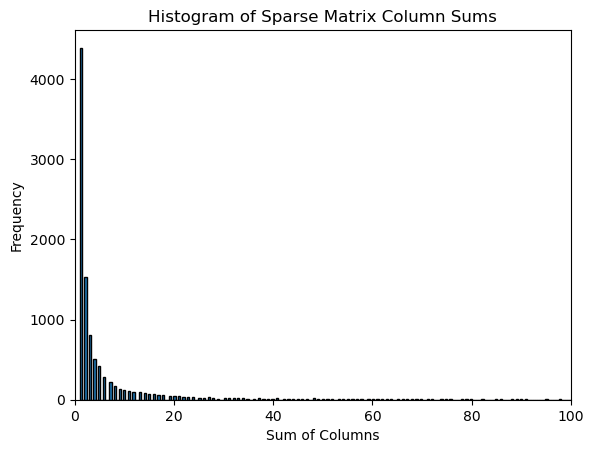

In [15]:
#statements_bow.sum(0)[0,25038]
column_sums = statements_bow.sum(axis=0).A1 
# Plot histogram of the column sums
plt.hist(column_sums, bins='auto', edgecolor='black')
plt.title('Histogram of Sparse Matrix Column Sums')
plt.xlabel('Sum of Columns')
plt.ylabel('Frequency')
plt.xlim(right=100, left = 0)
plt.show()

In [16]:
message4 = train_data['statement'][3]
print(message4)

Health care reform legislation is likely to mandate free sex change surgeries.


In [17]:
bow4 = bow_transformer.transform([message4])
print(bow4)
#print( bow_transformer.vocabulary_[('george','bush')])

  (0, 1694)	1
  (0, 1823)	1
  (0, 3927)	1
  (0, 4424)	1
  (0, 5452)	1
  (0, 5532)	1
  (0, 5723)	1
  (0, 7637)	1
  (0, 8336)	1
  (0, 9022)	1


In [18]:
print( 'sparse matrix shape:', statements_bow.shape)
print( 'number of non-zeros:', statements_bow.nnz)
print( 'sparsity: %.2f%%' % (100.0 * statements_bow.nnz / (statements_bow.shape[0] * statements_bow.shape[1])))

sparse matrix shape: (10240, 10262)
number of non-zeros: 104602
sparsity: 0.10%


In [19]:
tfidf_transformer = TfidfTransformer().fit(statements_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print( tfidf4)

  (0, 9022)	0.4485004763391605
  (0, 8336)	0.3473097166386551
  (0, 7637)	0.2877608171757143
  (0, 5723)	0.32876199049579224
  (0, 5532)	0.3458447813521655
  (0, 5452)	0.29483993033326344
  (0, 4424)	0.2057975549144545
  (0, 3927)	0.32194828975962103
  (0, 1823)	0.2987770785944325
  (0, 1694)	0.21335949537516585


In [20]:
print( tfidf_transformer.idf_[bow_transformer.vocabulary_['dog']] )

7.461565827835656


In [21]:
statements_tfidf = tfidf_transformer.transform(statements_bow)

In [22]:
%time fake_detector = MultinomialNB().fit(statements_tfidf, train_data['label'])

Wall time: 47.2 ms


In [23]:
print( 'predicted:', fake_detector.predict(tfidf4)[0])
print( 'expected:', train_data.label[3])

predicted: false
expected: false


In [24]:
all_predictions =fake_detector.predict(statements_tfidf)
print( all_predictions)

['false' 'half-true' 'half-true' ... 'half-true' 'false' 'false']


accuracy 0.5759765625
(row=expected, col=predicted)


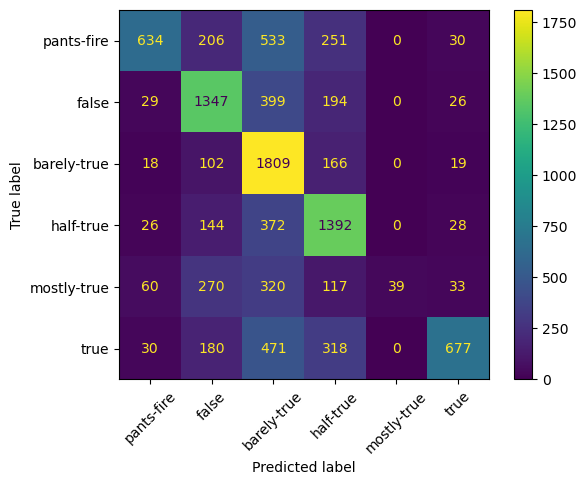

In [58]:
my_labels =  ['pants-fire','false','barely-true','half-true','mostly-true','true']
print( 'accuracy', accuracy_score(train_data['label'], all_predictions))
cm =  confusion_matrix(train_data['label'], all_predictions, labels = my_labels)
ConfusionMatrixDisplay.from_predictions(y_true = train_data['label'], y_pred = all_predictions , display_labels = my_labels, xticks_rotation = 45)
print( '(row=expected, col=predicted)')